In [11]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
from scipy.misc import imread
from scipy.misc import imshow


import warnings
warnings.filterwarnings("ignore")

### Load dataset info

In [31]:
path_to_train = 'train'
data = pd.read_csv('train.csv')

train_dataset_info = []
for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)

In [41]:
pic = train_dataset_info[2].get('path')+'_red.png'
pic

'train/000a9596-bbc4-11e8-b2bc-ac1f6b6435d0_red.png'

(512, 512)

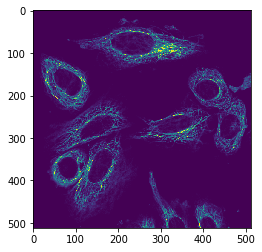

In [42]:
b = imread(pic)
plt.imshow(b)
b.shape

### Create datagenerator

In [34]:
class data_generator:
    
    def create_train(dataset_info, batch_size, shape, augument=True):
        assert shape[2] == 3
        while True:
            random_indexes = np.random.choice(len(dataset_info), batch_size)
            batch_images = np.empty((batch_size, shape[0], shape[1], shape[2]))
            batch_labels = np.zeros((batch_size, 28))
            for i, idx in enumerate(random_indexes):
                image = data_generator.load_image(
                    dataset_info[idx]['path'], shape)   
                if augument:
                    image = data_generator.augment(image)
                batch_images[i] = image
                batch_labels[i][dataset_info[idx]['labels']] = 1
            yield batch_images, batch_labels
            
    
    def load_image(path, shape):
        image_red_ch = skimage.io.imread(path+'_red.png')
        image_yellow_ch = skimage.io.imread(path+'_yellow.png')
        image_green_ch = skimage.io.imread(path+'_green.png')
        image_blue_ch = skimage.io.imread(path+'_blue.png')

        image_red_ch += (image_yellow_ch/2).astype(np.uint8) 
        image_green_ch += (image_yellow_ch/2).astype(np.uint8)

        image = np.stack((
            image_red_ch, 
            image_green_ch, 
            image_blue_ch), -1)
        image = resize(image, (shape[0], shape[1]), mode='reflect')
        return image
                
            
    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)
        
        image_aug = augment_img.augment_image(image)
        return image_aug


### Show data

In [35]:
# create train datagen
train_datagen = data_generator.create_train(
    train_dataset_info, 5, (299,299,3), augument=True)

min: 0.0, max: 1.0


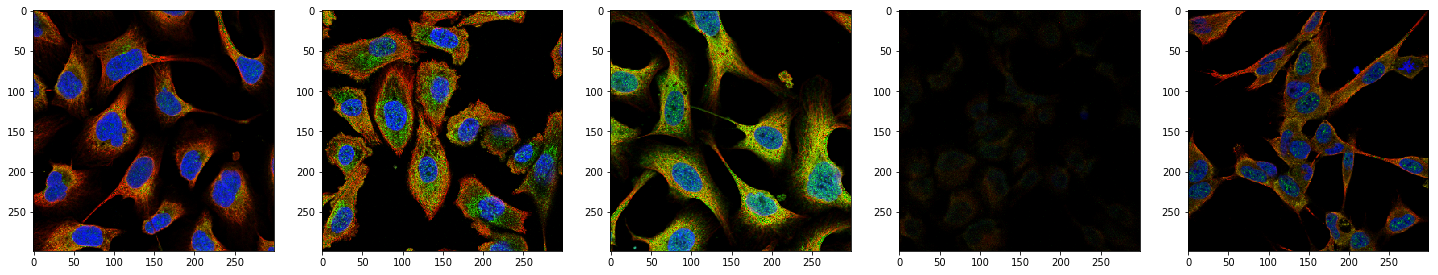

In [36]:
images, labels = next(train_datagen)

fig, ax = plt.subplots(1,5,figsize=(25,5))
for i in range(5):
    ax[i].imshow(images[i])
print('min: {0}, max: {1}'.format(images.min(), images.max()))

### Create model

In [37]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras

def create_model(input_shape, n_out):
    
    pretrain_model = InceptionResNetV2(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape)
    
    model = Sequential()
    model.add(pretrain_model)
    model.add(Flatten())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_out))
    model.add(Activation('sigmoid'))
    return model

In [38]:
keras.backend.clear_session()

model = create_model(
    input_shape=(299,299,3), 
    n_out=28)

model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(1e-04),
    metrics=['acc'])

model.summary()

TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("Placeholder:0", shape=(3, 3, 3, 32), dtype=float32) is not an element of this graph.

### Train model

In [ ]:
epochs = 100; batch_size = 16
checkpointer = ModelCheckpoint(
    '../working/InceptionResNetV2.model', 
    verbose=2, 
    save_best_only=True)

# split and suffle data 
np.random.seed(2018)
indexes = np.arange(train_dataset_info.shape[0])
np.random.shuffle(indexes)
train_indexes = indexes[:27500]
valid_indexes = indexes[27500:]

# create train and valid datagens
train_generator = data_generator.create_train(
    train_dataset_info[train_indexes], batch_size, (299,299,3), augument=True)
validation_generator = data_generator.create_train(
    train_dataset_info[valid_indexes], 100, (299,299,3), augument=False)

# train model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    validation_data=next(validation_generator),
    epochs=epochs, 
    verbose=1,
    callbacks=[checkpointer])

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[1].set_title('acc')
ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
ax[0].legend()
ax[1].legend()

### Create submit

In [ ]:
submit = pd.read_csv('../input/sample_submission.csv')

In [ ]:
%%time
predicted = []
for name in tqdm(submit['Id']):
    path = os.path.join('../input/test/', name)
    image = data_generator.load_image(path, (299,299,3))
    score_predict = model.predict(image[np.newaxis])[0]
    label_predict = np.arange(28)[score_predict>=0.5]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

In [ ]:
submit['Predicted'] = predicted
submit.to_csv('submission.csv', index=False)